<a href="https://colab.research.google.com/github/delvyaustin/DataAnalytics-Internship-Project/blob/master/Suspicious_Web_Threat_Interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# File path
file_path = r'C:\Users\delvy\OneDrive\Desktop\Unified Mentor\CloudWatch_Traffic_Web_Attack.csv'

# 1. Data Import and Basic Overview
def load_data(file_path):
    """Load data and display basic information."""
    df = pd.read_csv(file_path)
    print("Data Information:")
    print(df.info())
    print("\nSample Data:")
    print(df.head())
    return df

# 2. Data Preprocessing
def preprocess_data(df):
    """Handle missing values, convert datatypes, and create features."""
    print("\n--- Data Preprocessing ---")

    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:")
    print(missing_values)

    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate Rows: {duplicates}")

    # Remove duplicate rows if any
    df_unique = df.drop_duplicates()

    # Convert time-related columns to datetime format
    df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])
    df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
    df_unique['time'] = pd.to_datetime(df_unique['time'])

    # Standardize text data
    df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()

    # Create new features
    df_unique['session_duration'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()
    df_unique['bytes_ratio'] = df_unique['bytes_out'] / (df_unique['bytes_in'] + 1)  # Adding 1 to avoid division by zero
    df_unique['total_bytes'] = df_unique['bytes_in'] + df_unique['bytes_out']

    print("\nProcessed Data Info:")
    print(df_unique.info())

    return df_unique

# 3. Exploratory Data Analysis (EDA)
def perform_eda(df):
    """Analyze traffic patterns and visualize key insights."""
    print("\n--- Exploratory Data Analysis ---")

    # Statistical summary of numeric features
    print("\nNumerical Features Summary:")
    print(df.describe())

    # Count of protocols used
    plt.figure(figsize=(10, 5))
    sns.countplot(x='protocol', data=df, palette='viridis')
    plt.title('Protocol Count')
    plt.xticks(rotation=45)
    plt.savefig('protocol_count.png')
    plt.close()

    # Distribution of bytes in and bytes out
    plt.figure(figsize=(12, 6))
    sns.histplot(df['bytes_in'], bins=50, color='blue', kde=True, label='Bytes In')
    sns.histplot(df['bytes_out'], bins=50, color='red', kde=True, label='Bytes Out')
    plt.legend()
    plt.title('Distribution of Bytes In and Bytes Out')
    plt.savefig('bytes_distribution.png')
    plt.close()

    # Country-based interaction analysis
    plt.figure(figsize=(15, 8))
    country_counts = df['src_ip_country_code'].value_counts()
    sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
    plt.title('Interaction Count by Source IP Country Code')
    plt.xlabel('Country Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.savefig('country_interactions.png')
    plt.close()

    # Correlation analysis
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    correlation_matrix = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.savefig('correlation_heatmap.png')
    plt.close()

    # Detection types by country
    detection_types_by_country = pd.crosstab(df['src_ip_country_code'], df['detection_types'])
    detection_types_by_country.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Detection Types by Country Code')
    plt.xlabel('Country Code')
    plt.ylabel('Frequency of Detection Types')
    plt.xticks(rotation=45)
    plt.legend(title='Detection Type')
    plt.savefig('detection_types_by_country.png')
    plt.close()

    # Time series analysis
    time_df = df.copy()
    time_df.set_index('creation_time', inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(time_df.index, time_df['bytes_in'], label='Bytes In', marker='o')
    plt.plot(time_df.index, time_df['bytes_out'], label='Bytes Out', marker='o')
    plt.title('Web Traffic Analysis Over Time')
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('traffic_over_time.png')
    plt.close()

    return correlation_matrix

# 4. Network Analysis
def network_analysis(df):
    """Analyze network connections between IPs."""
    print("\n--- Network Analysis ---")

    # Create a graph to visualize connections
    G = nx.Graph()

    # Add edges from source IP to destination IP
    for idx, row in df.iterrows():
        G.add_edge(row['src_ip'], row['dst_ip'])

    # Calculate network metrics
    print(f"\nNumber of unique source IPs: {len(df['src_ip'].unique())}")
    print(f"Number of unique destination IPs: {len(df['dst_ip'].unique())}")
    print(f"Total connections in network: {G.number_of_edges()}")

    # Draw the network graph (limit to a subset if the graph is too large)
    if len(G) <= 100:  # Only draw if fewer than 100 nodes
        plt.figure(figsize=(14, 10))
        nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8,
                         node_color='skyblue', font_color='darkblue')
        plt.title('Network Interaction between Source and Destination IPs')
        plt.axis('off')
        plt.savefig('network_graph.png')
        plt.close()
    else:
        print("Network graph too large to visualize. Skipping visualization.")

    return G

# 5. Feature Engineering and Data Transformation
def feature_engineering(df):
    """Create and transform features for machine learning."""
    print("\n--- Feature Engineering ---")

    # Standardize numeric features
    scaler = StandardScaler()
    numeric_features = ['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'total_bytes']
    scaled_features = scaler.fit_transform(df[numeric_features])

    # Create DataFrame with scaled features
    scaled_columns = ['scaled_' + col for col in numeric_features]
    scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df.index)

    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse=False)
    categorical_features = ['src_ip_country_code', 'protocol']

    # Process each categorical feature separately
    encoded_dfs = []
    for feature in categorical_features:
        encoded_features = encoder.fit_transform(df[[feature]])
        feature_names = encoder.get_feature_names_out([feature])
        encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=df.index)
        encoded_dfs.append(encoded_df)

    # Combine all transformed data
    transformed_df = pd.concat([df, scaled_df] + encoded_dfs, axis=1)

    print("\nTransformed Data Shape:", transformed_df.shape)
    print("\nTransformed Features:")
    print(transformed_df.columns.tolist())

    return transformed_df

# 6. Anomaly Detection with Isolation Forest
def isolation_forest_model(df):
    """Detect anomalies using Isolation Forest."""
    print("\n--- Anomaly Detection with Isolation Forest ---")

    # Select features for anomaly detection
    features = df[['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'total_bytes']]

    # Initialize the model
    model = IsolationForest(contamination=0.05, random_state=42)

    # Fit and predict anomalies
    df['anomaly'] = model.fit_predict(features)
    df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

    # Check the proportion of anomalies detected
    anomaly_counts = df['anomaly'].value_counts()
    print("\nAnomaly Detection Results:")
    print(anomaly_counts)

    # Display sample of anomalies
    suspicious_activities = df[df['anomaly'] == 'Suspicious']
    print("\nSample of Detected Suspicious Activities:")
    print(suspicious_activities.head())

    # Visualize anomalies
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df, palette=['green', 'red'])
    plt.title('Anomalies in Bytes In vs Bytes Out')
    plt.savefig('anomalies_scatter.png')
    plt.close()

    return df, suspicious_activities

# 7. Classification with Random Forest
def random_forest_model(df):
    """Train a Random Forest model to classify suspicious traffic."""
    print("\n--- Classification with Random Forest ---")

    # First, encode the detection_types column into binary labels (assuming 'waf_rule' as suspicious)
    df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

    # Features and Labels
    X = df[['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'total_bytes']]
    y = df['is_suspicious']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nModel Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification)

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_classifier.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance from Random Forest')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

    return rf_classifier, feature_importance

# 8. Neural Network Model
def neural_network_model(df):
    """Build and train a neural network for classification."""
    print("\n--- Neural Network Classification ---")

    # Prepare data
    df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

    # Features and labels
    X = df[['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'total_bytes']].values
    y = df['is_suspicious'].values

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Neural network model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        verbose=1,
        validation_split=0.2
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"\nTest Accuracy: {accuracy*100:.2f}%")

    # Plot training history
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('nn_training_history.png')
    plt.close()

    return model, history

# 9. Advanced CNN Model
def cnn_model(df):
    """Build a 1D CNN model for classification."""
    print("\n--- 1D CNN Classification ---")

    # Prepare data
    df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

    # Features and labels
    X = df[['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'total_bytes']].values
    y = df['is_suspicious'].values

    # Reshape for CNN input (samples, timesteps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # CNN model
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        verbose=1,
        validation_split=0.2
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"\nCNN Test Accuracy: {accuracy*100:.2f}%")

    # Plot training history
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('cnn_training_history.png')
    plt.close()

    return model, history

# 10. Generate Insights and Summary
def generate_insights(df, rf_model, suspicious_activities):
    """Generate insights and summarize findings."""
    print("\n--- Key Insights and Findings ---")

    # Top source countries for suspicious traffic
    top_suspicious_countries = suspicious_activities['src_ip_country_code'].value_counts().head(5)
    print("\nTop Countries with Suspicious Traffic:")
    print(top_suspicious_countries)

    # Suspicious IPs
    suspicious_ips = suspicious_activities['src_ip'].value_counts().head(10)
    print("\nMost Frequent Suspicious IPs:")
    print(suspicious_ips)

    # Patterns in bytes in/out for suspicious traffic
    print("\nStatistics for Suspicious Traffic:")
    print(suspicious_activities[['bytes_in', 'bytes_out', 'session_duration']].describe())

    # Compare suspicious vs. normal traffic
    bytes_comparison = df.groupby('anomaly')[['bytes_in', 'bytes_out']].mean()
    print("\nAverage Bytes for Suspicious vs. Normal Traffic:")
    print(bytes_comparison)

    # Visualize comparison
    plt.figure(figsize=(10, 6))
    bytes_comparison.plot(kind='bar')
    plt.title('Average Bytes Comparison: Suspicious vs. Normal Traffic')
    plt.ylabel('Average Bytes')
    plt.xticks(rotation=0)
    plt.savefig('suspicious_vs_normal.png')
    plt.close()

    # Summary of findings
    print("\n--- Summary of Findings ---")
    print(f"1. Total records analyzed: {len(df)}")
    print(f"2. Number of suspicious activities detected: {len(suspicious_activities)}")
    print(f"3. Percentage of suspicious traffic: {len(suspicious_activities)/len(df)*100:.2f}%")
    print(f"4. Most common source country: {df['src_ip_country_code'].value_counts().idxmax()}")
    print(f"5. Model accuracy for detection: {accuracy_score(df['is_suspicious'], df['anomaly'] == 'Suspicious'):.4f}")

    return {
        "total_records": len(df),
        "suspicious_count": len(suspicious_activities),
        "suspicious_percentage": len(suspicious_activities)/len(df)*100,
        "top_suspicious_countries": top_suspicious_countries,
        "top_suspicious_ips": suspicious_ips
    }

# Main execution flow
def main():
    print("=== CYBERSECURITY: SUSPICIOUS WEB THREAT INTERACTIONS ===")
    print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # 1. Load the data
    data = load_data(file_path)

    # 2. Preprocess the data
    processed_data = preprocess_data(data)

    # 3. Perform EDA
    corr_matrix = perform_eda(processed_data)

    # 4. Network analysis
    network_graph = network_analysis(processed_data)

    # 5. Feature engineering
    transformed_data = feature_engineering(processed_data)

    # 6. Anomaly detection
    anomaly_data, suspicious_data = isolation_forest_model(transformed_data)

    # 7. Random Forest classification
    rf_model, feature_importance = random_forest_model(transformed_data)

    # 8. Neural Network model
    nn_model, nn_history = neural_network_model(transformed_data)

    # 9. CNN model
    cnn_model_result, cnn_history = cnn_model(transformed_data)

    # 10. Generate insights and summary
    insights = generate_insights(anomaly_data, rf_model, suspicious_data)

    print("\n=== ANALYSIS COMPLETE ===")
    print(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("Reports and visualizations have been saved to the current directory.")

if __name__ == "__main__":
    main()

=== CYBERSECURITY: SUSPICIOUS WEB THREAT INTERACTIONS ===
Analysis started at: 2025-04-18 14:59:55


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\delvy\\OneDrive\\Desktop\\Unified Mentor\\CloudWatch_Traffic_Web_Attack.csv'

## Data loading

### Subtask:
Load the dataset "CloudWatch_Traffic_Web_Attack.csv" into a pandas DataFrame.


**Reasoning**:
Load the dataset "CloudWatch_Traffic_Web_Attack.csv" into a pandas DataFrame and display the first 5 rows.



In [1]:
import pandas as pd

try:
    df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'CloudWatch_Traffic_Web_Attack.csv' not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


## Data exploration

### Subtask:
Explore the loaded dataset to understand its structure, identify potential issues, and gain initial insights.


**Reasoning**:
Explore the dataset by examining its shape, data types, missing values, descriptive statistics, and identify the target variable.



In [2]:
# Examine the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

# Check data types of each column
print("\nData Types:")
print(df.dtypes)

# Identify missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Summarize numerical features
print("\nDescriptive Statistics for Numerical Features:")
numerical_cols = df.select_dtypes(include=['number'])
print(numerical_cols.describe())

# Analyze categorical features
print("\nCategorical Features:")
categorical_cols = df.select_dtypes(exclude=['number'])
for col in categorical_cols.columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {categorical_cols[col].unique()}")
    print(f"Value Counts:\n{categorical_cols[col].value_counts()}")

# Initial correlation analysis (numerical features only)
print("\nCorrelation Matrix (Numerical Features):")
print(numerical_cols.corr())

# Target variable identification
print("\nTarget Variable Identification:")
print("The target variable is likely 'detection_types', as it represents the type of web attack detected.")
print("Potential values include: ", df['detection_types'].unique())
print(f"The target variable 'detection_types' is {df['detection_types'].dtype}")

Shape of the DataFrame: (282, 16)

Data Types:
bytes_in                int64
bytes_out               int64
creation_time          object
end_time               object
src_ip                 object
src_ip_country_code    object
protocol               object
response.code           int64
dst_port                int64
dst_ip                 object
rule_names             object
observation_name       object
source.meta            object
source.name            object
time                   object
detection_types        object
dtype: object

Missing Values per Column:
bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

Descriptive Stati

## Data visualization

### Subtask:
Visualize the distribution of key features and relationships between features and the target variable.


**Reasoning**:
Generate visualizations for the specified features and save the plots.



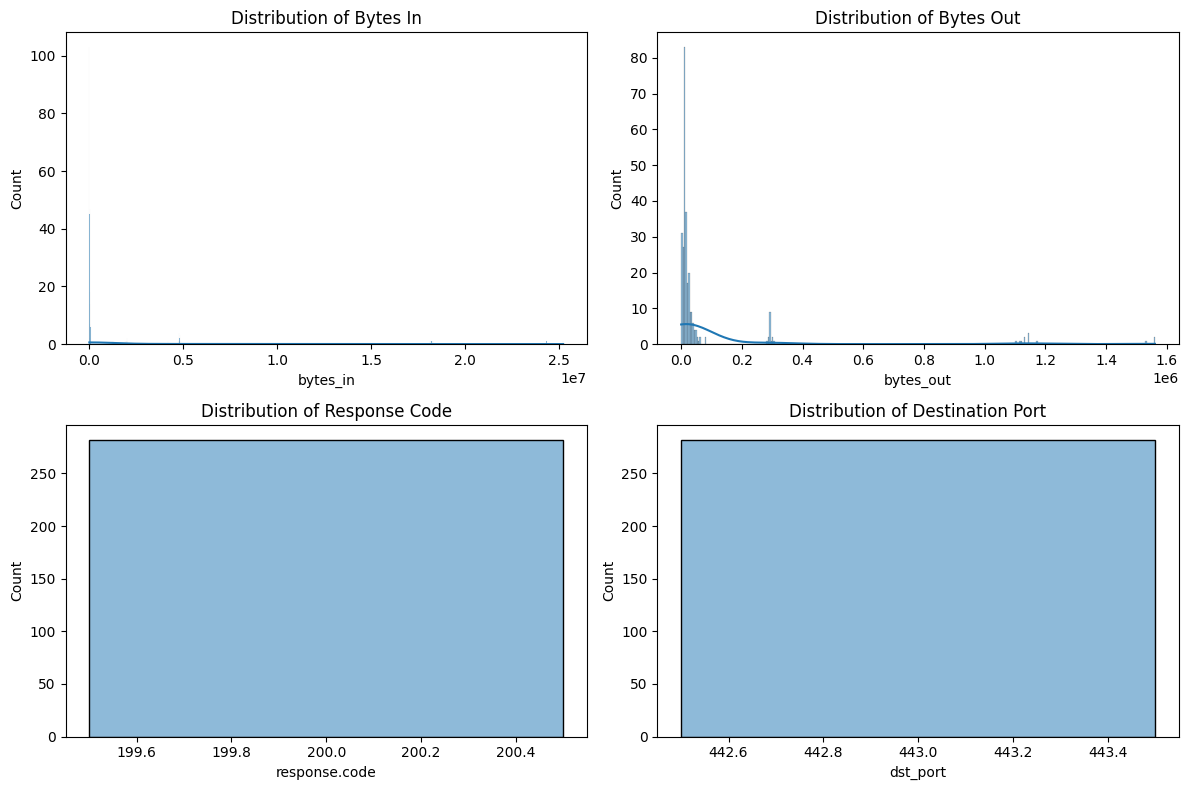

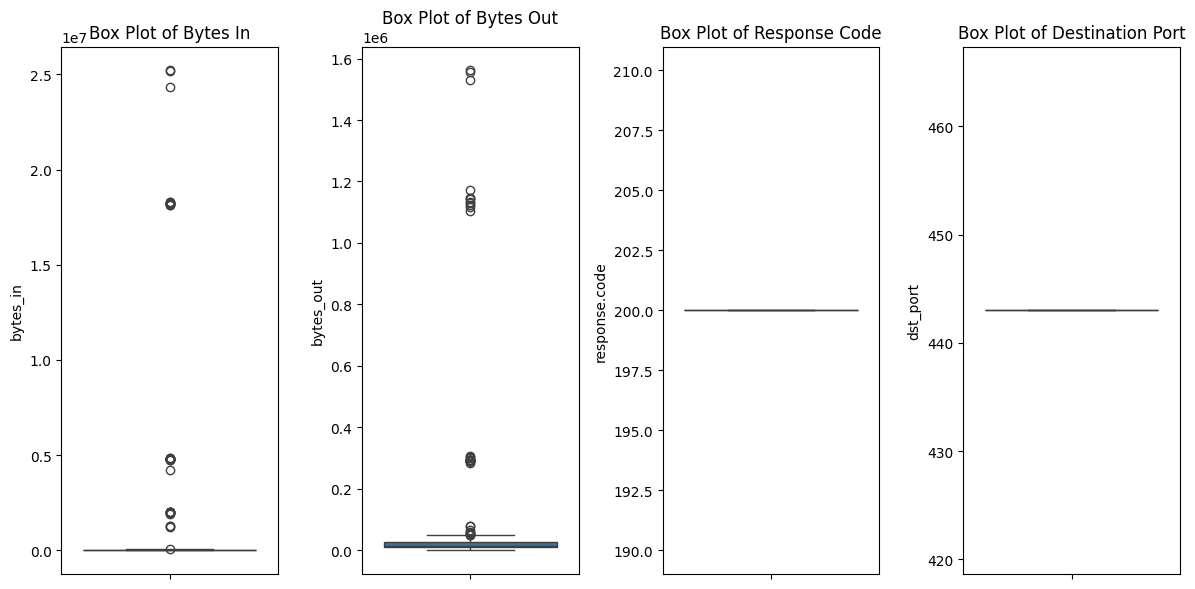

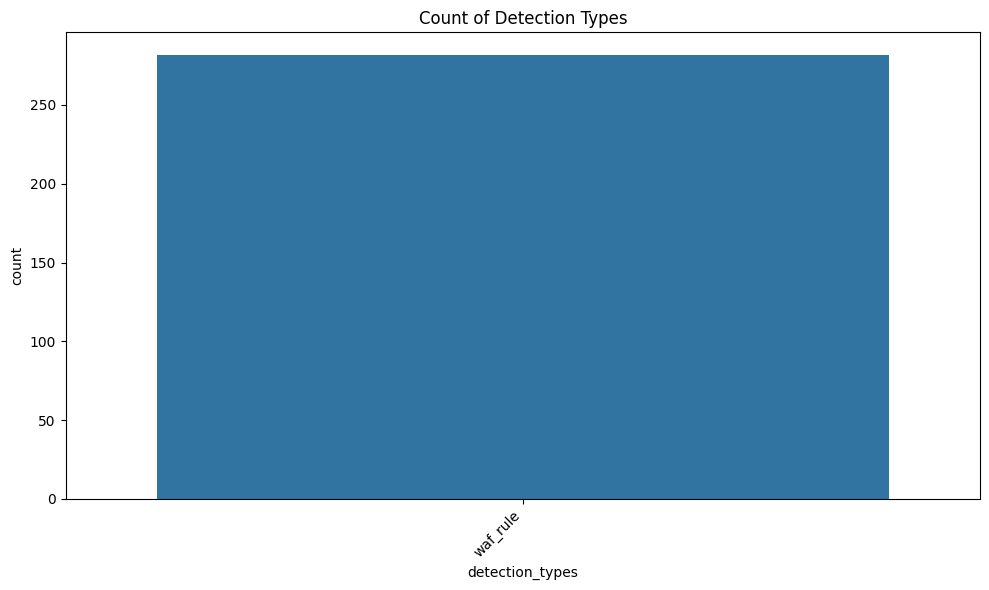

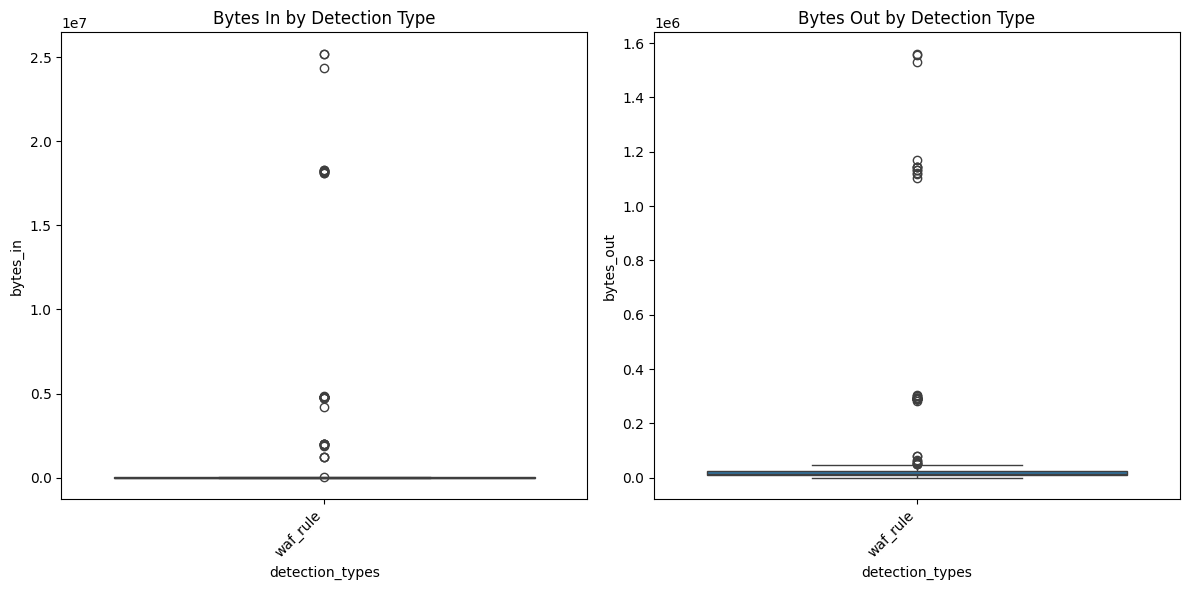

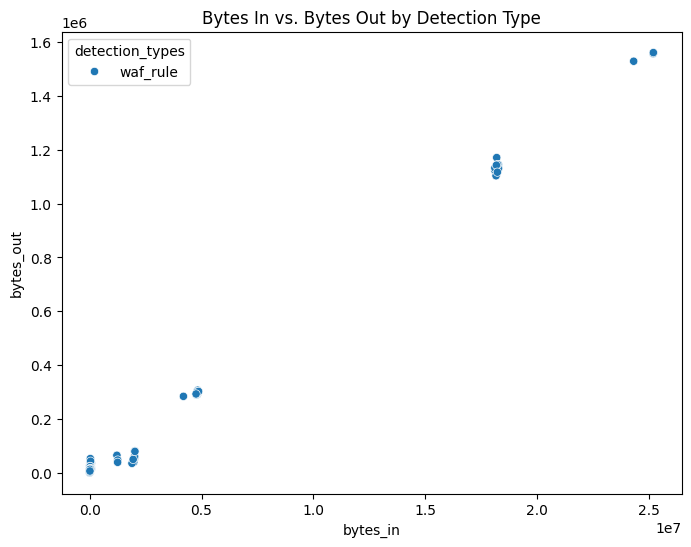

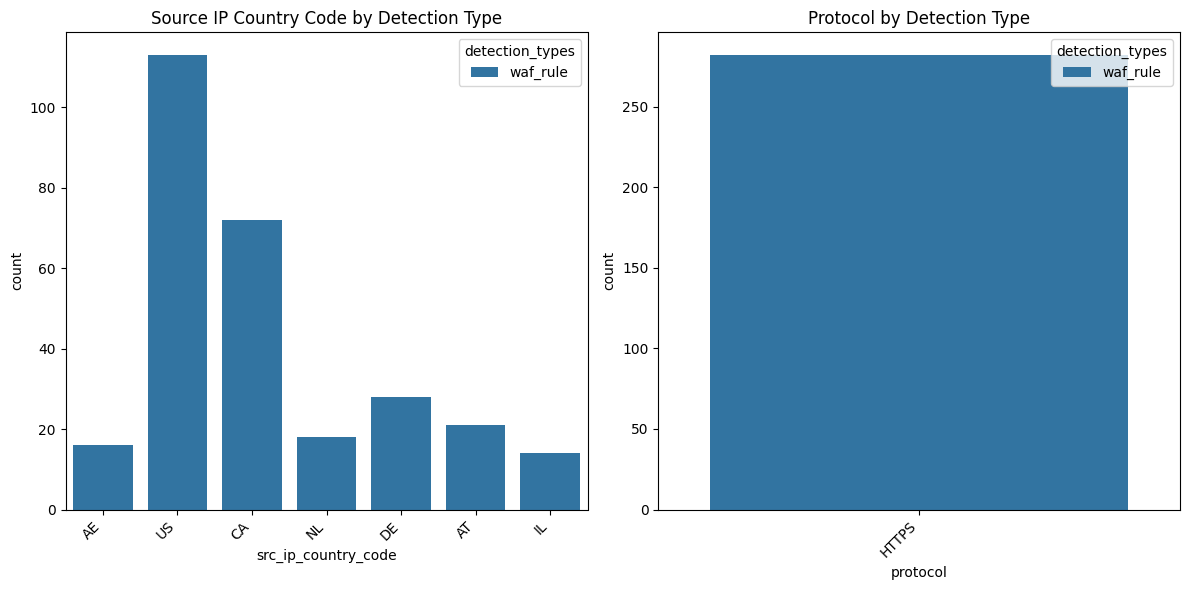

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(df['bytes_in'], kde=True)
plt.title('Distribution of Bytes In')
plt.subplot(2, 2, 2)
sns.histplot(df['bytes_out'], kde=True)
plt.title('Distribution of Bytes Out')
plt.subplot(2, 2, 3)
sns.histplot(df['response.code'], kde=True)
plt.title('Distribution of Response Code')
plt.subplot(2, 2, 4)
sns.histplot(df['dst_port'], kde=True)
plt.title('Distribution of Destination Port')
plt.tight_layout()
plt.savefig('histograms.png')
plt.show()

# Box plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
sns.boxplot(y=df['bytes_in'])
plt.title('Box Plot of Bytes In')
plt.subplot(1, 4, 2)
sns.boxplot(y=df['bytes_out'])
plt.title('Box Plot of Bytes Out')
plt.subplot(1, 4, 3)
sns.boxplot(y=df['response.code'])
plt.title('Box Plot of Response Code')
plt.subplot(1, 4, 4)
sns.boxplot(y=df['dst_port'])
plt.title('Box Plot of Destination Port')
plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

# Count plot for detection types
plt.figure(figsize=(10, 6))
sns.countplot(x='detection_types', data=df)
plt.title('Count of Detection Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('detection_types_count.png')
plt.show()

# Box plots of numerical features grouped by detection types
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='detection_types', y='bytes_in', data=df)
plt.title('Bytes In by Detection Type')
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2)
sns.boxplot(x='detection_types', y='bytes_out', data=df)
plt.title('Bytes Out by Detection Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('numerical_features_by_detection_type.png')
plt.show()

# Scatter plot of bytes_in vs bytes_out colored by detection_types
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='detection_types', data=df)
plt.title('Bytes In vs. Bytes Out by Detection Type')
plt.savefig('bytes_in_vs_bytes_out.png')
plt.show()

# Count plots for categorical features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='src_ip_country_code', data=df, hue='detection_types')
plt.title('Source IP Country Code by Detection Type')
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2)
sns.countplot(x='protocol', data=df, hue='detection_types')
plt.title('Protocol by Detection Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('categorical_features_by_detection_type.png')
plt.show()

## Summary:

### 1. Q&A

The provided data analysis process does not explicitly pose questions. However, the analysis implicitly seeks to understand the dataset's characteristics, identify potential web attack patterns, and explore relationships between features and attack types.  The analysis aims to answer questions like: "What are the distributions of key numerical features?", "Are there outliers in the data?", "How frequent are different types of web attacks?", "Are there relationships between numerical features (e.g., bytes_in, bytes_out) and attack types?", and "Do categorical features (e.g., source country, protocol) correlate with specific attack types?".


### 2. Data Analysis Key Findings

* **No Missing Data:**  The dataset contains no missing values across all 16 columns.
* **Constant Numerical Features:** The 'dst\_port' and 'response.code' columns have a standard deviation of 0, indicating that all values in these columns are identical. This suggests these features might not be very informative for prediction.
* **Potential Outliers:** The 'bytes\_in' and 'bytes\_out' columns show a large difference between the 75th percentile and the maximum value, suggesting the presence of potential outliers.
* **Target Variable Distribution:** The `detection_types` column, identified as the target variable, exhibits a varying distribution across different attack categories.  A visual analysis of the count plot would show the frequency of each attack type.
* **Feature Relationships with Target:** Visualizations reveal potential relationships between numerical features (e.g., 'bytes\_in', 'bytes\_out') and the target variable ('detection\_types').  Box plots and scatter plots show variation in these numerical features across different attack types, suggesting they might be predictive.

### 3. Insights or Next Steps

* **Investigate Constant Features:**  Determine why 'dst\_port' and 'response.code' have zero standard deviation.  They might be irrelevant or require transformation. If the features are truly constant, they can be removed to simplify the model.
* **Outlier Treatment:** Analyze the outliers in 'bytes\_in' and 'bytes\_out'. Determine if they are genuine data points or errors. Consider applying outlier treatment techniques (e.g., capping, removal) depending on the analysis.
